<a href="https://colab.research.google.com/github/andrefsc/SDC_M04/blob/main/zTarea_Modulo_6_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Master en Inteligência Artificial en el Deporte, Edición 8**

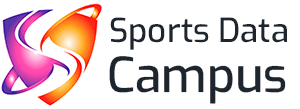

__Tarea Individual Módulo 6 - Parte 1__
````
Análisis de sentimiento con BERT : Reviews de Películas

La primera parte de esta tarea consiste en utilizar el modelo BERT para realizar un análisis de sentimiento de reviews de películas.

Utilizaremos el notebook Tarea_Modulo_6_Parte_1.ipynb cómo plantilla, donde se necesitan completar varias celdas del notebook con
el código necesario para realizar las tareas que se piden (Instrucciones al principio del notebook).
Además, se deben contestar un par de preguntas sobre el desarrollo al final del notebook.

---

André Silveira Castanho
April, 2024

`````

El ambiente virtual de Google Colab ya incluye muchas de las bibliotecas comúnmente usadas en tareas de inteligencia artificial. No obstante, es necesario añadir la biblioteca **transformers** de Huggingface y **tqdm**, que facilita la visualización de barras de progreso en bucles for.

In [1]:
!pip install transformers
!pip install tqdm

# 0. Imports

En la sección `Imports` agrupamos todas las librerías y clases que debemos importar en esta tarea.

In [ ]:
# import basic libraries for data science
import pandas as pd # para manipulación y análisis de datos
import numpy as np # para operaciones matemáticas de alto nivel
import matplotlib.pyplot as plt # para la visualización de datos

# import torch and transformers
import torch # el framework principal para operaciones con tensores y redes neuronales
from torch import cuda # de PyTorch, para operaciones en GPUs
from torch.utils.data import Dataset, DataLoader # para manejar y cargar datos en formato adecuado para entrenar modelos con PyTorch
from transformers import AutoModelForSequenceClassification, AutoTokenizer # de la biblioteca transformers, para cargar modelos preentrenados
                                                                           # y tokenizadores que se ajustan automáticamente al modelo

# import different metrics for evaluation
# Para evaluar el rendimiento de modelos de clasificación
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

# import tqdm to track progress
from tqdm import tqdm # para mostrar barras de progreso en bucles, facilitando el seguimiento de largas ejecuciones

# import some python modules required for some of the utility functions
import itertools # ofrece construcciones eficientes de bucles
import re # para operaciones de expresiones regulares
import os # para interactuar con el sistema operativo, como manejo de archivos y directorios

# 1. Utils

En la sección `Utils` se encuentran varias funciones de utilidad con sus docstrings que se utilizarán a largo de la implementación para preprocesar y limpiar datos y también evaluar los resultados.

Aquí encontrais la función `text_cleaning()` sobre la que teneis que responder unas preguntas.

In [ ]:
################################
# text processing and cleaning #
################################

def encode_sentiment(sentiment):
  """
  Label encode sentiment.

  Parameters
  ----------
  sentiment: str, sentiment {"positive", "sentiment"}

  Returns
  -------
  int, 1's for positive and 0's for negative

  """
  if sentiment == "positive":
    return 1
  else:
    return 0

def is_ascii(w):
  """
  Check if character is ascii type.

  Parameters
  ----------
  w: str, character

  Returns
  -------
  bool, True if character is ascii. False otherwise.
  """
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters
  ----------
  text: string, text data

  Returns
  -------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text

##############
# Evaluation #
##############

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# 2. Config

En la sección `Config` definimos variables y objetos que utilizaremos en el desarrollo y queremos tener agrupados en el mismo lugar.

In [ ]:
# Defining some key variables that will be used later on
MAX_LEN = 512 # max number of tokens
BATCH_SIZE = 64
SEED = 42 # for reprodudible results

# Initialiaze model tokenizer
TOKENIZER = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Setting up the device for GPU usage if available
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

cpu


# 3. Data

En la sección `Data` necesitamos cargar los datos en un dataframe de pandas, codificar el sentimiento y limpiar el texto.

Podeis hacer uso de las funciones de utilidad `encode_sentiment()` y `text_cleaning()`.

In [ ]:
### 1. Escribir código para cargar los datos y codificar la columna sentiment.###
### Sustituir None por el código necesario ###
raw_data = None

In [ ]:
raw_data.head()

In [ ]:
### 2. Escribir código para limpiar el texto utilizando la función text_cleaning() ###
### Sustituir None por el código necesario ###
cleaned_data = raw_data.copy()
cleaned_data["review"] = None

# 4. Dataset and Dataloader

En la sección `Dataset and Dataloader` vamos a crear un dataset de Pytorch del tipo map-iterable que utilizaremos para almacenar los datos y procesarlos de acuerdo a los requirimientos del modelo.

Después creamos un objeto `DataLoader` de Pytorch que toma el dataset para poder pasar ejemplos al modelo en lotes o batches.

__Clase DistilBertDataset__

La clase `DistilBertDataset` toma como argumentos un dataframe con los datos, el tokenizador del modelo y el número de máximo de tokens que definimos en la sección `Config`.

El método `__getitem__()` toma como parámetro un índice de los datos en el dataset, extrae el ejemplo correspondiente del dataframe y utiliza la función `encode_plus()` del tokenizador para procesar los inputs de acuerdo a los requerimientos de DistilBERT ( special tokens [CLS] y [SEP], truncation, padding, etc.). Este método devuelve un diccionario de python con los tensores que continen los inputs ids, los attention masks y el sentimiento codificado.

El método `__len__()` simplemente devuelve el número de ejemplos en el dataset.

__DataLoader__

El `DataLoader` viene a ser un generador que devulve lotes de tamaño `BATCH_SIZE` para alimentar el modelo.

En sus parámetros podemos definir el tamaño de lote o batch size, si seleccionar de forma aleatoria los ejemplos a incluir en el batch o no (recomendable al realizar un entrenamiento) y también el número de workers a utilizar (2 para Google Colab).

In [ ]:
class DistilBertDataset(Dataset):
  """Custom pytorch map-iterable dataset for sentiment analysis with DistilBERT."""
  def __init__(self, dataframe, tokenizer, max_len):
      self.len = len(dataframe)
      self.data = dataframe
      self.tokenizer = tokenizer
      self.max_len = max_len

  def __getitem__(self, index):
      text = str(self.data['review'].loc[index])
      text = " ".join(text.split())
      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=False,
          truncation=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']

      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'targets': torch.tensor(self.data['sentiment'].loc[index], dtype=torch.long)
      }

  def __len__(self):
      return self.len

In [ ]:
### 3. Escribir código para crear un objeto DistilBertDataset con los inputs ###
### limpios, el tokenizador del modelo y el máximo número de tokens ###
### Sustituir None por el código necesario ###
dataset = None

In [ ]:
print("---- Visually inspecting 5th element ----")
print(f"Input ids: {dataset[6]['ids']}")
print(f"Attention masks: {dataset[6]['mask']}")
print(f"Target: {dataset[6]['targets']}")
print("------------------------------------------")

In [ ]:
# define dataloader params
dataloader_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 2
                }

# create dataloader
data_loader = DataLoader(dataset, **dataloader_params)

# 5. Model

En la sección `Model` creamos la clase DistilBERTClass() con el modelo ya ajustado que se encuentra en el hub de modelos de Huggingface.

El método `forward()` de la clase toma los inputs ids y attention mask que devuelve el método `__getitem__()` de la clase `DistilBertDataset`.

In [ ]:
class DistilBERTClass(torch.nn.Module):
  """Custom class for DilstilBERT model for Sequence Classification."""
  def __init__(self):
      super(DistilBERTClass, self).__init__()
      self.model = AutoModelForSequenceClassification \
        .from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

  def forward(self, input_ids, attention_mask):
      output = self.model(input_ids=input_ids, attention_mask=attention_mask)
      logits = output.logits

      return logits

# 6. Inference

En la sección `Inference` vamos a utilizar el modelo para realizar inferencia y obtener los sentimientos de las reviews.

Después utilizamos la función `inference()` para obtener las predicciones.


In [ ]:
# Download and load trained DistilBERT model
model = DistilBERTClass()
model.to(DEVICE)

In [ ]:
def inference(data_loader, model, device):
    """
    Binary classification using DistilBERT model.

    Parameters
    ----------
    data_loader: Pytorch DataLoader object
    model: DistilBERTClass Object
    device: str, device

    Returns
    -------
    lists, outputs logits and targets
    """
    # put model in evaluation mode
    model.eval()
    # create lists to be populated with predictions and corresponding targets
    fin_targets = []
    fin_outputs = []
    # do not calculate gradients as not required for inference
    with torch.no_grad():
        # loop over batches and get predictions
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            targets = d['targets']

            # send them to the cuda device we are using
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)
            # get outputs logits
            outputs = model(
                input_ids=ids,
                attention_mask=mask
            )
            # Normalize logits and store results and targets in lists
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
# run inference -> sentiment analysis
outputs, targets = inference(
    data_loader=data_loader,
    model=model,
    device=DEVICE
)

In [ ]:
### 4. Escribir código obtener las predicciónes a partir de las logits normalizadas ###
### Criterio: Elegir la clase más probable ###
### La función de numpy np.argmax() puede ser de gran ayuda ;) ###
### Sustituir None por el código necesario ###
outputs = None

# 7. Evaluation

En la sección `Evaluation` calculamos métricas típicas de un poblema de clasificación binario: Accuracy y F1 Score.

También graficamos la matriz de confusión utlizando la función de utilidad `plot_confusion_matrix()`.

Finalmente, hacemos una pequeña evaluación visual de los inputs, los targets y las predicciones.

In [ ]:
### 5. Escribir código para calcular accuracy y f1_score ###
### Sustituir None por el código necesario ###
accuracy = None
f_score = None
print(f"Training Accuracy Score = {accuracy}")
print(f"Training F1-Score = {f_score}")

In [ ]:
# classification report
print(classification_report(targets, outputs, target_names=["Negative", "Positive"]))

In [ ]:
# print the confusion matrix
cnf_matrix = confusion_matrix(targets, outputs, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix'
)

In [ ]:
#visual evalution
for review, target, output in zip(cleaned_data.review.values[:10], targets, outputs):
  print(f"Text: {review}")
  print(f"Target: {target}\tOutput: {output}\n")

# 8. Preguntas

### 8.1. La función `text_cleaning` se utiliza para limpiar el texto de caracteres, puntuación, etc. que añaden ruido a los datos y dificultan el aprendizaje. ¿Cuál crees que ha sido el proceso para identificar los requerimientos de limpieza de los datos y que se ven reflejados es esta función? ¿Crees que se podría mejorar esta función?

Respuesta:

### 8.2. En la plantilla, ¿Cuál es el propósito de la siguiente línea de código?

`model.to(DEVICE)`

Respuesta: